# Toy Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from loss_cal.tasks.toy_example import ToyExample
from loss_cal.costs import StepCost_weighted
from loss_cal.utils.plot import plot_step_loss
from loss_cal.utils.utils import load_data
from loss_cal.predictor import train, build_nn

plot_config_file = "loss_cal/utils/.matplotlibrc"

## Set Up

In [3]:
toy = ToyExample(action_type="binary", num_actions=2)
toy.task_name

'toy_example'

Prior and Simulator

In [4]:
prior = toy.get_prior()
simulator = toy.get_simulator()

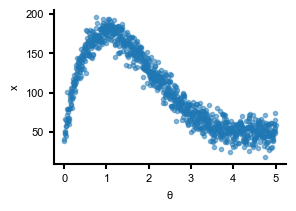

In [5]:
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    thetas = torch.linspace(0, 5, 1000)
    ax.scatter(thetas, simulator(thetas), alpha=0.5)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel("x")
    #ax.set_title("joint")
    plt.savefig("./results/toy_example/joint.pdf")
        #'results/1d_classifier/1D_clf_joint.pdf')
    plt.show()

Posterior

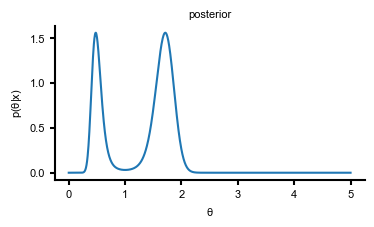

In [6]:
lower = 0
upper = 5
resolution = 1000
x_o = 150
posterior_evals = toy.gt_posterior(torch.Tensor([x_o]))
with mpl.rc_context(fname=plot_config_file):
    fig, ax = plt.subplots(1, 1, figsize=(4, 2))
    thetas = torch.linspace(lower, upper, resolution)
    ax.plot(thetas, posterior_evals)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$p(\theta|x)$")
    ax.set_title("posterior")
    plt.show()

## Binary Actions

### Decision Task

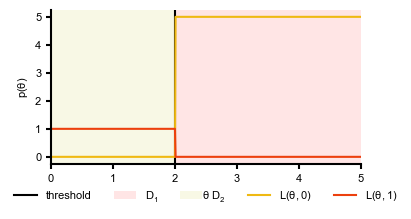

In [7]:
threshold = 2.0
costs = [5.0, 1.0]
cost_fn = StepCost_weighted(costs, threshold=threshold)
plot_step_loss(cost_fn, lower, upper, threshold, resolution=500, plot_config_file=plot_config_file)

### Load data

In [8]:
n_train = 2000 #50_000
n_test = 5_000
n_actions = 2

theta_train, x_train, theta_val, x_val, theta_test, x_test = load_data("toy_example")
theta_train = theta_train[: n_train]
x_train = x_train[: n_train]
theta_val = theta_val[: n_test]
x_val = x_val[: n_test]
theta_test = theta_test[: n_test ]
x_test = x_test[: n_test]

print(f"N_train = {theta_train.shape[0]}, N_val = {theta_val.shape[0]}, N_test = {theta_test.shape[0]}")

Load data from './data/toy_example', device = cpu.
N_train = 2000, N_val = 5000, N_test = 5000


### Train a neural network to predict expected costs

In [9]:
nn = build_nn(
    model="fc",
    x_train=x_train,
    action_train=toy.actions.sample(x_train.shape[0]),
    hidden_dims=[50, 50, 50],
    output_dim=1,
    activation=torch.nn.Sigmoid(),
    output_transform=torch.nn.Identity(),
)
print(nn, end="\n-----\n")

nn, train_loss, val_loss = train(
    model=nn,
    x_train=x_train,
    theta_train=theta_train,
    cost_fn=cost_fn,
    x_val=x_val,
    theta_val=theta_val,
    actions=toy.actions,
    learning_rate=1e-3,
    model_dir="./results/toy_example/binary/notebook",
    stop_after_epochs=40,
    # max_num_epochs=10
)

FeedforwardNN(
  (standardize_layer): Standardize()
  (input_layer): Linear(in_features=2, out_features=50, bias=True)
  (hidden_layers): ModuleList(
    (0-1): 2 x Linear(in_features=50, out_features=50, bias=True)
  )
  (final_layer): Linear(in_features=50, out_features=1, bias=True)
  (activation): ReLU()
  (output_transform): ReLU()
)
-----
Subdirectory 'checkpoints' already exists. Delete first if wanted.
Converged after 206 epochs. train_loss = 0.99083502	 last_improvement = 14


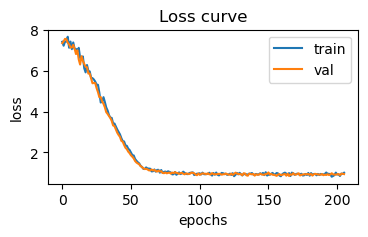

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(train_loss, label="train")
ax.plot(val_loss, label="val")
ax.set_title("Loss curve")
ax.set_xlabel("epochs")
ax.set_ylabel("loss")
ax.legend()
plt.show()

### Evaluate model

Check predictions on the training data

In [11]:
actions_evaluate = toy.actions.sample(x_train.shape[0])
predictions_train = nn(x_train, actions_evaluate)
true_expected_costs_train = torch.Tensor([toy.expected_posterior_costs_binary(x_o) for x_o in x_train])

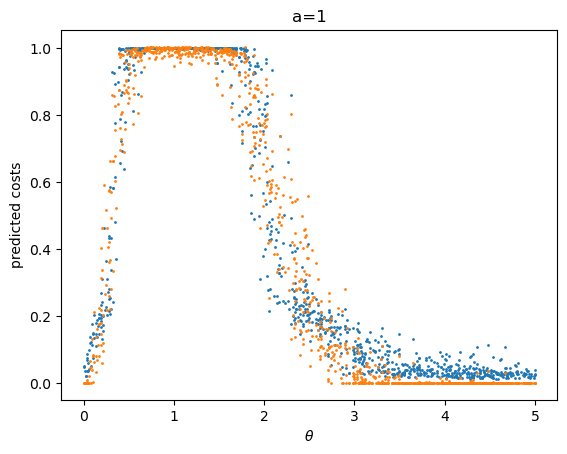

In [12]:
a = 1
cond = actions_evaluate == a
plt.scatter(theta_train[cond].numpy().squeeze(), true_expected_costs_train[(cond).squeeze(), a], s=1)
plt.scatter(theta_train[cond].numpy().squeeze(), predictions_train[cond].detach().numpy().squeeze(), s=1)
plt.title(f"a={a}")
plt.xlabel(r"$\theta$")
plt.ylabel("predicted costs")
plt.show()

In [13]:
# MSE
print(
    f"MSE for expected costs given a={a}: {((nn(x_train, torch.ones_like(x_train)*a).squeeze() - true_expected_costs_train[:,a])**2).mean():.6f}"
)

MSE for expected costs given a=1: 0.003155


Check posterior ratios on training data

In [14]:
ratios_train_posterior = torch.as_tensor(
    [toy.posterior_ratio_binary(x, cost_fn=cost_fn) for x in x_train]
).unsqueeze(1)
preds_train_0 = nn(x_train, torch.zeros_like(actions_evaluate))
preds_train_1 = nn(x_train, torch.ones_like(actions_evaluate))
ratios_nn_train = preds_train_0 / (preds_train_0 + preds_train_1)

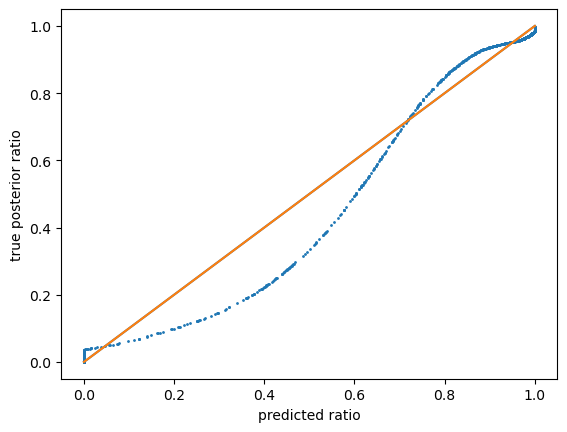

In [15]:
plt.plot([(0, 0), (1, 1)])
plt.scatter(ratios_nn_train.detach().numpy(), ratios_train_posterior.numpy(), s=1)
plt.xlabel("predicted ratio")
plt.ylabel("true posterior ratio")
# plt.savefig("results/toy_example/fig_continuous_clf_ratios.png")
plt.show()